In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data to a DataFrame
final_data = pd.read_csv("data/Data Files/final_data_non-normalized.csv")
final_data.shape

(14023, 178)

In [3]:
# Find columns with missing values and their number of missing values
missing_counts = final_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

for col, count in missing_counts.items():
    print(f"{col}: {count} missing values")

In [6]:
# Standardize data for the regression
final_data_standardized = final_data.copy()
cols_to_standardize = final_data.columns[2:-1]
scaler = StandardScaler()
final_data_standardized[cols_to_standardize] = scaler.fit_transform(final_data[cols_to_standardize])
final_data_standardized

,Date,CUSIP,Stock_return,SP500_return,Firm age,Liquidity of market assets,Amihud Measure,Capital turnover,Change in common equity,Book-to-market equity,...,TMAX_IOWA,TMIN_IOWA,AWND_IOWA,PRCP_MINNESOTA,SNOW_MINNESOTA,SNWD_MINNESOTA,TMAX_MINNESOTA,TMIN_MINNESOTA,AWND_MINNESOTA,time_idx
0,2001-03-31,00104Q10,-0.469413,-1.597463,-2.785675,-3.647106,0.588008,0.875024,3.186276,1.458345,...,-1.103734,-0.923097,-0.151921,-0.755572,-0.545442,2.941506,-0.952320,-0.956316,-0.329318,14
1,2001-04-30,00104Q10,1.525564,1.652447,2.297999,3.096595,-1.419264,1.264484,-4.072511,-1.228553,...,0.350823,0.096070,2.266748,2.235119,-0.545442,0.222968,0.082128,0.008079,2.522177,15
2,2001-05-31,00104Q10,-0.509716,-0.000497,-0.101250,-0.906577,2.458590,-0.478632,1.351398,0.432490,...,0.469097,0.561433,0.865110,0.913651,-0.545442,0.316692,0.571958,0.600217,0.425706,16
3,2001-06-30,00104Q10,-1.063396,-0.694041,0.519758,0.039997,2.593808,-0.134020,0.429156,0.175144,...,0.951067,0.993608,-0.455166,1.904784,-0.545442,0.410416,1.030777,1.043636,0.105656,17
4,2001-07-31,00104Q10,0.906728,-0.366051,-2.049932,-1.928613,-1.028006,1.889961,2.155129,0.570690,...,1.293575,1.419789,-1.011312,-0.257868,-0.545442,0.504140,1.366350,1.355144,-0.315955,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14018,2017-04-30,L0084910,-0.311123,0.091709,0.149847,0.989015,-0.089948,0.613152,-0.386171,-0.565318,...,0.178979,0.187361,0.742897,0.949384,-0.461609,-0.559812,0.155144,0.137896,0.692525,207
14019,2017-05-31,L0084910,-0.144259,0.148978,-0.043925,0.808408,-1.394986,0.539824,-0.544162,-1.040826,...,0.625151,0.524545,0.265062,1.053391,-0.545442,-0.574454,0.543052,0.519826,0.472477,208
14020,2017-06-30,L0084910,-0.722101,-0.006858,0.345927,-0.270599,1.268727,-0.769943,0.017231,0.390272,...,1.266619,1.127181,0.007244,0.840591,-0.545442,-0.574454,1.169893,1.116583,0.368021,209
14021,2017-07-31,L0084910,0.036150,0.328114,0.125117,-0.465376,-0.342884,-1.068642,-0.134362,0.145865,...,1.428841,1.461017,-1.352017,0.232179,-0.545442,-0.574454,1.330217,1.339296,-1.425104,210


In [7]:
# Find the best Ridge model

random_state = 42

def find_best_ridge_model(df, alphas):
    """
    Trains Ridge regression models over a range of alpha values, evaluates their performance,
    and returns the best-performing model based on highest R^2 and lowest MSE.
    :param df: A pandas DataFrame containing predictor variables, the target column 'Stock_return',
               and the columns 'Date', 'CUSIP', and 'time_idx'.
    :param alphas: A list of alpha values (regularization strengths) to test in Ridge regression.
    :return:
        - best_model: The Ridge model with the best R^2 (and lowest MSE tie-breaker).
        - best_alpha: The alpha value corresponding to the best model.
        - perf_df: A DataFrame summarizing R^2 and MSE for each alpha tested.
    """

    # Separate features (X) and target (y)
    X = df.drop(columns=['Date', 'CUSIP', 'Stock_return', 'time_idx'])
    y = df['Stock_return']

    records = []  # To store performance metrics for each alpha
    models = {}   # To store trained models keyed by alpha

    # Loop through each alpha
    for alpha in alphas:
        model = Ridge(alpha=alpha, random_state=random_state)
        model.fit(X, y) # Fit model on entire dataset

        # Predict and evaluate performance
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)

        # Store metrics and model
        records.append({
            'alpha': alpha,
            'r2': r2,
            'mse': mse
        })
        models[alpha] = model

    # Create a performance DataFrame indexed by alpha
    perf_df = pd.DataFrame.from_records(records).set_index('alpha')

    # Sort by highest R^2, and lowest MSE as tie-breaker
    perf_sorted = perf_df.sort_values(
        ['r2', 'mse'],
        ascending=[False, True]
    )

    # Select the best alpha and corresponding model
    best_alpha = perf_sorted.index[0]
    best_model = models[best_alpha]

    return best_model, best_alpha, perf_df

# Define a list of alpha values to test
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

# Run model selection on the standardized dataset
best_model, best_alpha, performance = find_best_ridge_model(
    df=final_data_standardized,
    alphas=alphas
)

# Output results
print(f"Best alpha : {best_alpha}")
print(performance.sort_values('r2', ascending=False))

Best alpha : 0.0001
              r2       mse
alpha                     
0.0001  0.164912  0.835088
0.0010  0.164912  0.835088
0.0100  0.164912  0.835088
0.1000  0.164911  0.835089
1.0000  0.164889  0.835111


In [8]:
## Apply model to data and get coefficients

# Drop non-feature columns
X = final_data_standardized.drop(columns=['Date', 'CUSIP', 'Stock_return', 'time_idx'])

# Create a pandas Series of the model coefficients, indexed by feature names
coefs = pd.Series(best_model.coef_, index=X.columns)

# Reorder the coefficients by their absolute value in descending order
coefs_series = coefs.reindex(coefs.abs().sort_values(ascending=False).index)

# Convert the sorted coefficient series to a dictionary
coefs_dict = coefs_series.to_dict()

pd.set_option("display.max_rows", None)
coefs_dict

{'TMIN_IOWA': 0.6671840071544884,
 'TMIN_NEBRASKA': -0.618982559594055,
 'TMIN_SODAKOTA': 0.4962208119011919,
 'TMAX_IOWA': -0.47629824131770543,
 'Idiosyncratic volatility from the Fama-French 3-factor model': 0.3706592196049966,
 'Net stock issues': 0.36069253084792186,
 'TMAX_INDIANA': 0.3311803532231037,
 'Share turnover': -0.3242139749130014,
 'Idiosyncratic volatility from the q-factor model': -0.3217442673966798,
 'Equity net payout': -0.31413834364775456,
 'TMIN_INDIANA': -0.2946562410437522,
 'Cash-based operating profits-to-book assets': 0.2811509730455032,
 'Operating cash flow-to-market': -0.26319148251033525,
 'Cash-based operating profits-to-lagged book assets': -0.2605929546577944,
 'Firm age': 0.25857407163370716,
 'TMAX_NEBRASKA': 0.25049293786370375,
 'Earnings-to-price': 0.24001503085188908,
 'TMAX_MINNESOTA': -0.23573193078979088,
 'SP500_return': 0.22701802896535225,
 'Amihud Measure': -0.2107449391095082,
 'Free cash flow-to-price': 0.20500603801904566,
 'Quarterl

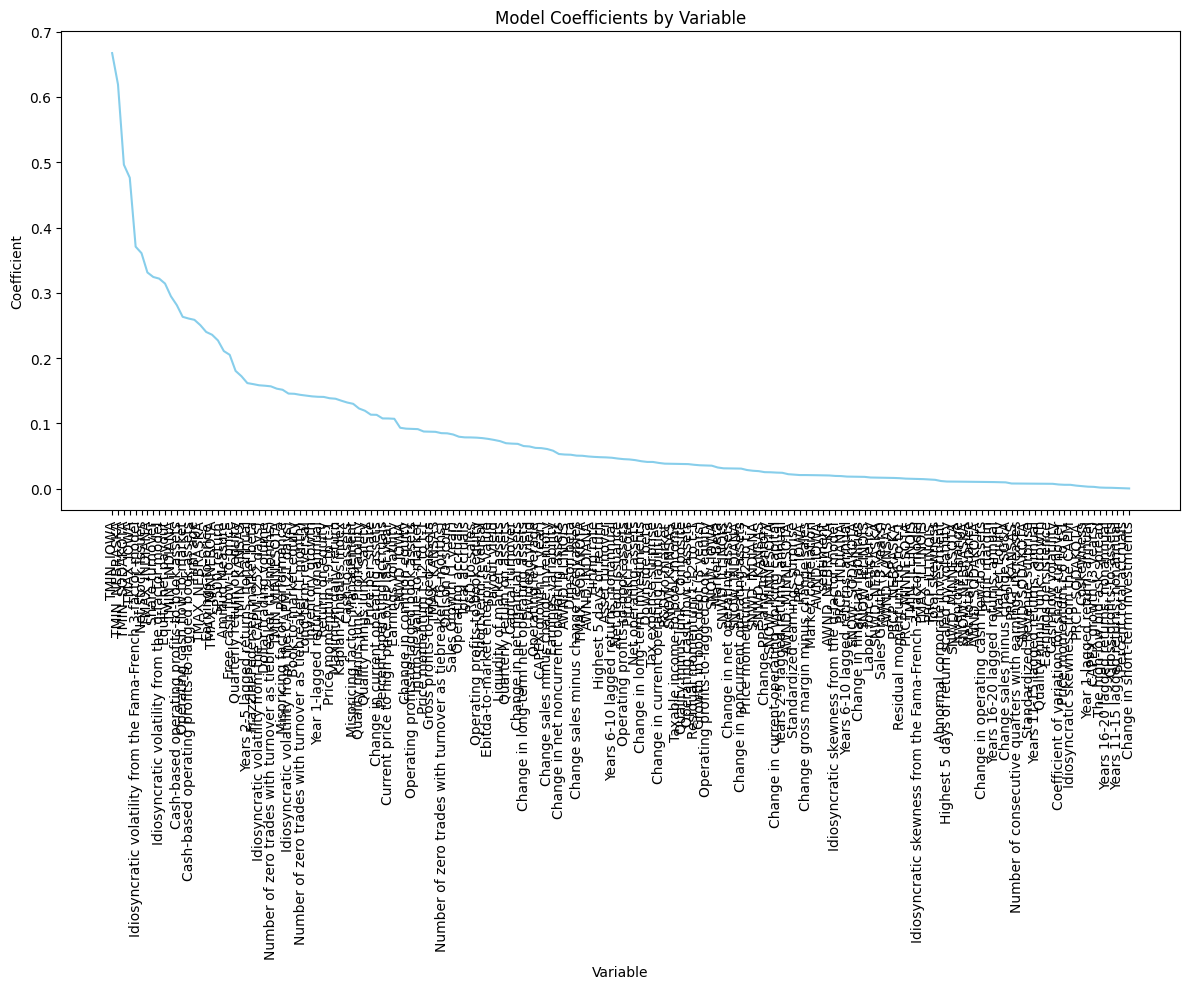

In [9]:
variables = list(coefs_dict.keys()) # extract features from the dictionary
coefficients = [abs(v) for v in coefs_dict.values()] # extract absolute value of coefficients from the dictionary

# Plot the coefficients in descending order
plt.figure(figsize=(12, 10))
plt.plot(variables, coefficients, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Model Coefficients by Variable')
plt.tight_layout()
plt.show()

In [10]:
# List of important features (if their coeff is greater or equal to 0.05)
important_features = [var for var, coef in coefs_dict.items() if abs(coef) >= 0.05]
print(important_features)
print(len(important_features))

['TMIN_IOWA', 'TMIN_NEBRASKA', 'TMIN_SODAKOTA', 'TMAX_IOWA', 'Idiosyncratic volatility from the Fama-French 3-factor model', 'Net stock issues', 'TMAX_INDIANA', 'Share turnover', 'Idiosyncratic volatility from the q-factor model', 'Equity net payout', 'TMIN_INDIANA', 'Cash-based operating profits-to-book assets', 'Operating cash flow-to-market', 'Cash-based operating profits-to-lagged book assets', 'Firm age', 'TMAX_NEBRASKA', 'Earnings-to-price', 'TMAX_MINNESOTA', 'SP500_return', 'Amihud Measure', 'Free cash flow-to-price', 'Quarterly return on equity', 'TMIN_KANSAS', 'Years 2-5 lagged returns, nonannual', 'Frazzini-Pedersen market beta', 'Idiosyncratic volatility from the CAPM (252 days)', 'Dollar trading volume', 'Number of zero trades with turnover as tiebreaker (12 months)', 'TMIN_MINNESOTA', 'Mispricing factor: Performance', 'Idiosyncratic volatility from the CAPM (21 days)', 'Book-to-market equity', 'Number of zero trades with turnover as tiebreaker (1 month)', 'Long-term revers

In [11]:
# List of non-important features (if their coeff is smaller than 0.05)
not_important_features = [var for var, coef in coefs_dict.items() if abs(coef) < 0.05]
print(not_important_features)
print(len(not_important_features))

['AWND_INDIANA', 'Hiring rate', 'Highest 5 days of return', 'Asset turnover', 'Years 6-10 lagged returns, nonannual', 'Net debt issuance', 'Operating profits-to-book assets', 'Pitroski F-score', 'Net operating assets', 'Change in long-term investments', 'Downside beta', 'Tax expense surprise', 'Change in current operating liabilities', 'R&D-to-market', 'SNOW_KANSAS', 'Taxable income-to-book income', 'Quality minus Junk: Composite', 'Operating cash flow to assets', 'Residual momentum t-12 to t-1', 'Growth in book debt (3 years)', 'Operating profits-to-lagged book equity', 'SNOW_IOWA', 'Market Beta', 'SNWD_ILLINOIS', 'Change in net operating assets', 'SNOW_INDIANA', 'Change in noncurrent operating assets', 'Price momentum t-12 to t-7', 'SNWD_INDIANA', 'SNWD_KANSAS', 'Change PPE and Inventory', 'SNOW_MINNESOTA', 'Change in current operating working capital', 'Years 2-5 lagged returns, annual', 'AWND_MINNESOTA', 'Standardized earnings surprise', 'PRCP_IOWA', 'Change gross margin minus chan